# Link Prediction

Build a GNN to predict links in a citation graph of academic papers.

The citation graph we will use for training this GNN is the [CORA Dataset](https://relational.fit.cvut.cz/dataset/CORA) available from the `torch_geometric.datasets.Planetoid` package.

## Setup

The following two cells import Pytorch Geometric (PyG) and a couple of supporting Pytorch packages that are customized against the torch version.

In [ ]:
import torch
torch.__version__

'1.9.0+cu111'

In [ ]:
%%capture
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html
!pip install -q torch-geometric

## Dataset

The CORA dataset consists of a single graph consisting of 2,708 academic papers. Here is the output of printing `dataset[0]` from the [node classification example solution](02-node-classification.ipynb).

```
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
```

The partitioning in different splits is achieved using the different masks. For edge prediction, however, we want to look at edges, so we will apply a transform to the Planetoid dataset to split the dataset randomly by edge.

In addition, we will add negative examples, i.e. edges that don't occur in the graph.

* Compose a transform consisting of `torch_geometric.transforms.NormalizeFeatures` and `torch_geometric.transforms.RandomLinkSplit`. 
* The `NormalizeFeatures` transform normalizes the node feature vector elements so they add up to 1. This is to normalize the vectors so their dot product is the same as cosine similarity, a value between 0 (negative pair label) and 1 (positive pair label).
* The `RandomLinkSplit` splits the graph into subgraphs by edge. Split the graph such that 85% edges are in the training split, 5% edges are in the validation split and 10% edges in the test split.
* Add negative training samples, i.e. edges that don't exist in the training subgraph and with an `edge_label` of 0. This is to allow the GNN to see negative examples during training. Add an equal number of negative samples as positive examples. You can do so by setting the `add_negative_train_samples` parameter of `RandomLinkSplit` to `True`.
* Set this transform to the `Planetoid` call to download the CORA dataset using the `transform` parameter, this will automatically create 3 edge-oriented data splits, with additional attributes in their corresponding `Data` objects as shown below.

```
(
    Data(x=[2708, 1433], edge_index=[2, 8976], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_label=[8976], edge_label_index=[2, 8976]),
    Data(x=[2708, 1433], edge_index=[2, 8976], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_label=[526], edge_label_index=[2, 526]),
    Data(x=[2708, 1433], edge_index=[2, 9502], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_label=[1054], edge_label_index=[2, 1054])
)
```

Compute and verify the following on the downloaded dataset.

* Number of (node) features (should be 1,433)
* Number of target classes (should be 7)
* The contents of the first element of the dataset should consist of 3 `Data` elements as shown above.

In [ ]:
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid

In [ ]:
# your code here

## DataLoader

The `Data` splits do not lend themselves to batch level training. For this exercise, we will work with each subgraph in its entirety.

Note that you could create `DataLoaders` from the splits by doing this:

`train_loader = DataLoader([train_dataset], shuffle=True, ...)`

but it will result in a single batch.

Separate the splits into a `train_dataset`, `val_dataset` and `test_dataset`.

In [ ]:
from torch_geometric.loader import DataLoader

In [ ]:
# your code here

## Model

Conceptually, we generate encodings for each node participating in an edge (positive or negative) and compute the similarity between all pairs of nodes. The network learns to push positive node pairs closer together and negative node pairs further apart using gradient descent.

From an implementation point of view, the node embeddings are learned on the entire subgraph in one shot, then the source and destination node vectors are separated out and the similarities between them computed.

Implement a network with the following layers.

1. _k_ layers of `GCNConv`, the first one with input dimension `input_dim` and output dimension `hidden_dim`, and the other _k-1_ layers with input and output dimention `hidden_dim`.
2. All `GCNConv` layers are followed by a `BatchNorm1d` layer.
3. Except for the last `GCNConv` + `BatchNorm1d` pair, all are followed by a `Droput` layer and a `ReLU` activation layer.
4. The output of the last `GCNConv` + `BatchNorm1d` is separated into source and destination nodes by calling `torch.index_select` on the output and the first and second rows of the `edge_label_index`.
5. The similarity between all source and destination nodes is computed by computing the dot product of the source and destination nodes.
6. Because our vectors are pre-normalized, the dot product is the same as cosine similarity, and the range of values corresponds to the labels 0 and 1 for negative and positive pair respectively.

Verify that your network design is sound by sending the training dataset through a newly instantiated instance.

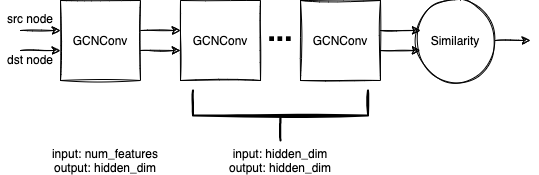

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn

In [ ]:
# your code here

## Training Loop

As in the previous exercises, organize your code into a `train_step`, `eval_step` and `train_loop`.

The target here is also binary, i.e. there may exist an edge between a pair of nodes or not, so once again we will use the ROC-AUC metric rather than accuracy to evaluate our model.

In this case, since the graphs cannot be batched (using a DataLoader will iterate over a single batch), we can compute the ROC-AUC directly in the `train_step` and `eval_step` functions rather than postponing the computation in the `train_loop` function. As before, you should use the [Scikit-Learn ROC-AUC metric](https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics) to compute the AUC metric.

### train_step

  1. In the `train_step` generate the predictions by running the `train_dataset` through the model, computing the loss, backpropagating the gradient of the loss and updating the model weights.
  2. Compute the AUC score for the entire dataset using the Scikit-Learn function [roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)
  3. Report the loss and AUC score over the entire dataset.

### eval_step

  1. Generate the predictions against the validation or test dataset using the current state of the model. As before, compute the loss and AUC score, but do not backpropagate.

### train_loop

  1. Run the `train_step` and `eval_step` over the required number of epochs.

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
# your code here

## Train

Train the model using the hyperparameters listed below. Use the Adam optimizer. Plot the training plots.

In [ ]:
# model parameters
INPUT_DIM = dataset.num_features
HIDDEN_DIM = 128
OUTPUT_DIM = dataset.num_classes
NUM_GCN_LAYERS = 3
DROPOUT_PCT = 0.5

# optimizer
LEARNING_RATE = 1e-2

NUM_EPOCHS = 100

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# your code here

## Evaluation

Evaluate the model against the `test_dataset` and report the AUC score.

In [ ]:
# your code here